In [114]:
import pandas as pd
import numpy as np 
import math
import time
import operator

from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn import naive_bayes
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing

import xgboost as xgb

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [115]:
# get data
train_data = pd.read_csv('/data/numerai_datasets/numerai_training_data.csv')
test_data = pd.read_csv('/data/numerai_datasets/numerai_tournament_data.csv')

In [116]:
#extract ID
ids = test_data.values[:,0]
test_data.drop(['t_id'], axis=1, inplace=True)

In [117]:
print "train: ", train_data.shape
print "test: ", test_data.shape

train:  (173844, 51)
test:  (264876, 50)


In [118]:
train_data.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,target
0,0.779178,0.426433,0.418566,0.579897,0.602174,0.617476,0.188963,0.664685,0.548962,0.428120,...,0.535529,0.364819,0.077530,0.552827,0.500349,0.428212,0.483159,0.378898,0.513796,1.0
1,0.402661,0.495588,0.550416,0.477632,0.634254,0.464662,0.530294,0.449357,0.561896,0.465977,...,0.352428,0.375022,0.328490,0.511662,0.591985,0.610517,0.519224,0.504858,0.543675,0.0
2,0.610055,0.735762,0.471352,0.376581,0.424241,0.634603,0.537878,0.461875,0.473637,0.523092,...,0.631627,0.607680,0.421754,0.731068,0.546721,0.568324,0.554409,0.527078,0.345822,0.0
3,0.530662,0.686998,0.515438,0.349434,0.392786,0.548612,0.412165,0.584493,0.466360,0.410736,...,0.642372,0.659400,0.473683,0.627518,0.462646,0.583620,0.469193,0.496289,0.408408,0.0
4,0.528537,0.414375,0.438764,0.633382,0.698721,0.735739,0.422502,0.600763,0.564069,0.600499,...,0.503946,0.537543,0.461172,0.405962,0.336028,0.606189,0.402953,0.459636,0.550660,0.0


In [119]:
test_data.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50
0,0.551578,0.423408,0.586551,0.608602,0.555070,0.571722,0.329937,0.656111,0.444510,0.540420,...,0.415784,0.614258,0.372983,0.406283,0.303399,0.324381,0.378367,0.562815,0.557074,0.394284
1,0.449299,0.560560,0.609896,0.363990,0.597433,0.479346,0.604371,0.317177,0.410328,0.611256,...,0.430137,0.400794,0.594452,0.405482,0.606372,0.686569,0.497322,0.498925,0.467430,0.444281
2,0.473734,0.557514,0.513725,0.527157,0.633930,0.586415,0.481549,0.435379,0.428335,0.636190,...,0.587222,0.526623,0.553604,0.528161,0.411759,0.498373,0.497864,0.544716,0.465167,0.476862
3,0.620427,0.594424,0.580931,0.314285,0.423363,0.411158,0.211485,0.751215,0.386131,0.364518,...,0.579057,0.685474,0.545053,0.410498,0.499253,0.540373,0.399592,0.709642,0.389209,0.272742
4,0.571241,0.371137,0.510843,0.592152,0.672221,0.694275,0.464046,0.525699,0.480996,0.717445,...,0.475188,0.527591,0.527959,0.448573,0.365735,0.376801,0.456864,0.390449,0.476513,0.461004


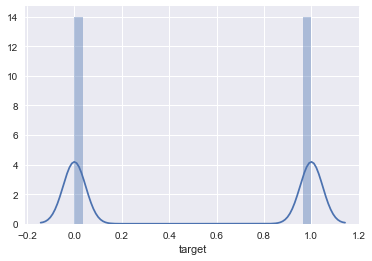

In [120]:
sns.distplot(train_data['target'])

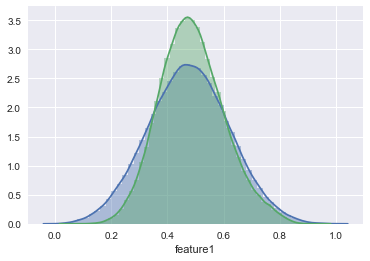

In [121]:
sns.distplot(train_data['feature1'])
sns.distplot(test_data['feature1'])

### Train vs. Test data Separation

In [122]:
train_data['train'] = 1
test_data['train'] = 0

In [123]:
data = pd.concat([train_data,test_data])
data = data.sample(frac=1).reset_index(drop=True)
data.drop(['target'], axis=1, inplace=True)

In [124]:
data.head()

,feature1,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,...,feature47,feature48,feature49,feature5,feature50,feature6,feature7,feature8,feature9,train
0,0.409820,0.485308,0.444221,0.348130,0.454486,0.297873,0.729325,0.437933,0.635335,0.546634,...,0.533207,0.577295,0.438643,0.370309,0.319058,0.394034,0.485081,0.399322,0.236957,0
1,0.497011,0.277236,0.574991,0.434549,0.527416,0.241473,0.566472,0.388516,0.531271,0.372881,...,0.608346,0.569624,0.396241,0.306273,0.438603,0.477398,0.214044,0.834428,0.493163,1
2,0.527797,0.335222,0.567754,0.396917,0.487801,0.288371,0.387974,0.438899,0.627053,0.345886,...,0.392403,0.755311,0.395345,0.250002,0.271645,0.414778,0.179050,0.804032,0.389593,0
3,0.465000,0.646479,0.517000,0.350357,0.526281,0.409515,0.532982,0.515485,0.536728,0.738880,...,0.544388,0.436506,0.347899,0.683614,0.523475,0.609035,0.561118,0.354365,0.469054,0
4,0.392787,0.655099,0.565935,0.641587,0.690903,0.624252,0.433765,0.334973,0.491463,0.733001,...,0.565274,0.430772,0.581992,0.645776,0.514079,0.740582,0.576624,0.495313,0.641490,0


In [125]:
# split
X_train, X_test, y_train, y_test = model_selection.train_test_split(data.values[:,:-1], data.values[:,-1], train_size=0.7)

In [126]:
# classify: train or test?
clf = xgb.XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.01, seed=0).fit(X_train, y_train)

In [127]:
def evaluate_clf(clf, X_train, X_test, y_train, y_test):
    train_probas = clf.predict_proba(X_train)
    train_predictions = clf.predict(X_train)
    test_probas = clf.predict_proba(X_test)
    test_predictions = clf.predict(X_test)

    print 'precision (on train):', metrics.precision_score(y_train, train_predictions, average='weighted')
    print 'precision:', metrics.precision_score(y_test, test_predictions, average='weighted')

    print 'recall (on train):', metrics.recall_score(y_train, train_predictions, average='weighted')
    print 'recall:', metrics.recall_score(y_test, test_predictions, average='weighted')

    print 'log loss (on train):', metrics.log_loss(y_train, train_probas)
    print 'log loss:', metrics.log_loss(y_test, test_probas)

In [128]:
evaluate_clf(clf, X_train, X_test, y_train, y_test)

precision (on train): 0.849028824346
precision: 0.829943316315
recall (on train): 0.822998072314
recall: 0.80735624848
log loss (on train): 0.508869030187
log loss: 0.519133025397


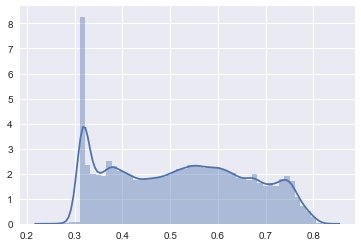

In [129]:
# plot probabilities of test instances appear in train
probas = clf.predict_proba(test_data.values[:,:-1])[:,1]
sns.distplot(probas)

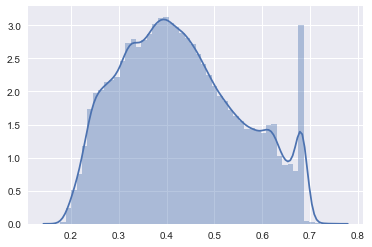

In [130]:
# plot probabilities of train instances appear in test
probas = clf.predict_proba(train_data.values[:,:-2])[:,0]
sns.distplot(probas)

In [131]:
# take train instances that probably appear in test
test_probas = probas.argsort()
train_data['train'] = probas

In [132]:
quantiles = np.percentile(probas, [25, 50, 75])
print 'quantiles:', quantiles

quantiles: [ 0.3324479   0.41764614  0.51741868]


In [133]:
# slice instances
train_data = train_data.iloc[test_probas]
train_data = train_data[train_data['train'] >= quantiles[1]]
train_data = train_data.reset_index(drop=True)

In [134]:
# drop tmp cols
train_data.drop(['train'], axis=1, inplace=True)
test_data.drop(['train'], axis=1, inplace=True)

In [135]:
print 'reduced train:', train_data.shape

reduced train: (86922, 51)


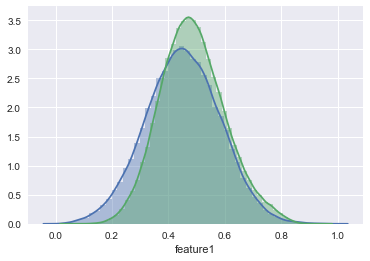

In [136]:
sns.distplot(train_data['feature1'])
sns.distplot(test_data['feature1'])

# Feature Engineering

In [ ]:
# add polynomial features
data = pd.concat([train_data, test_data])
data = data.reset_index(drop=True)

In [ ]:
poly = preprocessing.PolynomialFeatures(interaction_only=True)
poly.fit(data.values[:,:-1])

In [ ]:
target = train_data['target']
train_data = pd.DataFrame(poly.transform(train_data.values[:,:-1]))
test_data = pd.DataFrame(poly.transform(test_data.values))
train_data['target'] = target.values

In [ ]:
train_data.head()

# Data Preprocessing

In [ ]:
#numerical & categorical features
numerical = train_data._get_numeric_data().columns
categorical = [item for item in train_data.columns if item not in numerical]
categorical_indexes = [train_data.columns.get_loc(x) for x in categorical]

In [ ]:
#LabelEncoder
for x in categorical:
    le = preprocessing.LabelEncoder()
    le.fit(train_data[x])
    train_data[x] = le.transform(train_data[x])
    
    le = preprocessing.LabelEncoder()
    le.fit(test_data[x])
    test_data[x] = le.transform(test_data[x])    

In [ ]:
# MinMaxScaler
print 'before scaling:', train_data.min().min(), train_data.max().max()
target = train_data['target']

for x in test_data:
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(pd.concat([train_data[x], test_data[x]]).values.reshape(-1, 1))
    train_data[x] = scaler.transform(train_data[x].values.reshape(-1, 1))
    test_data[x] = scaler.transform(test_data[x].values.reshape(-1, 1)) 
    
train_data['target'] = target    

print 'after scaling:', train_data.min().min(), train_data.max().max()

In [ ]:
train_data.head()

# Feature Importance

In [ ]:
def rank_features_xgb(df, model):
    # fit 
    model.fit(df.values[:,:-1], df.values[:,-1])   

    #list feature importance
    imp_dict = model.booster().get_fscore()
    imp_dict = sorted(imp_dict.items(), key=operator.itemgetter(1), reverse=True)

    imp_arr = np.asarray(imp_dict)
    indices = np.empty([imp_arr.shape[0], 0])

    for x in imp_arr[:,0]:
        indices = np.append(indices, x.replace('f', ''))

    indices = indices.astype(int)
    importances = imp_arr[:,1].astype(int)    

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(indices.shape[0] - 1):
        print f, 'index', indices[f], df.columns[indices[f]], importances[f]    

    # Plot the feature importances of the forest
    plt.figure(figsize=(15,5))
    plt.title("Feature importances")
    plt.bar(range(indices.shape[0]), importances[:indices.shape[0]], color="r", align="center")
    plt.xticks(range(df.shape[1]), indices)
    plt.xlim([-1, df.shape[1]])
    plt.show()         

    # plot via xgb
    fig, ax = plt.subplots(1,1,figsize=(15,10))
    xgb.plot_importance(model, ax=ax)     
    
    return indices

In [ ]:
def rank_features_sklearn(df, model):
    # supervised ranking
    model.fit(df.values[:,:-1], df.values[:,-1])
    
    #list feature importance
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(df.shape[1] - 1):
        print f, 'index', indices[f], df.columns[indices[f]], importances[indices[f]]
        
    # Plot the feature importances of the forest
    plt.figure(figsize=(15,5))
    plt.title("Feature importances")
    plt.bar(range(df.shape[1] - 1), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(df.shape[1]), indices)
    plt.xlim([-1, df.shape[1]])
    plt.show()
    
    return indices

In [ ]:
model = ensemble.ExtraTreesClassifier(n_estimators = 100, max_depth=10, random_state=0)
indices_sklearn = rank_features_sklearn(train_data, model)

In [ ]:
model = xgb.XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.01, seed=0)
indices_xgb = rank_features_xgb(train_data, model)

# Feature Selection

In [ ]:
def select_features(features, indices, df_train, df_test):
    # create new feature list
    cols = []

    for f in range(features):
        cols.append(df_train.columns[indices[f]])        
        
    print cols    
    
    # reduce df for selected cols
    df_test = pd.DataFrame(df_test, columns=cols)
    cols.append('target')
    df_train = pd.DataFrame(df_train, columns=cols)
    
    return df_train, df_test

In [ ]:
# combine two methods for the feature selection
topk = 100
indices = np.concatenate((indices_sklearn[:topk], indices_xgb[:topk]), axis=0)
indices = np.unique(indices)

In [ ]:
train_data, test_data = select_features(indices.shape[0], indices, train_data, test_data)

# Create Models

In [137]:
#generate classifiers
clfs = {
    'GaussianNB' : naive_bayes.GaussianNB(),
    'SGD' : linear_model.SGDClassifier(random_state=1, loss='log', n_iter=1000),
    'XGB' : xgb.XGBClassifier(n_estimators=100, max_depth=10, seed=1),
    'LR' : linear_model.LogisticRegression(max_iter=1000, random_state=1)
}

In [138]:
#LR lbfgs
for p1 in ['l2']:
    for p2 in [1, 10, 100, 1000]:
        for p3 in [True, False]:
            for p4 in [None, 'balanced']:
                key = 'LR' + ', penalty=' + str(p1) + ', C=' + str(p2) + ', fit_intercept=' + str(p3) + ', class_weight=' + str(p4) + ', solver=lbfgs'
                value = linear_model.LogisticRegression(max_iter=1000, random_state=1, penalty=p1, C=p2, fit_intercept=p3, class_weight=p4, solver='lbfgs')
                clfs[key]=value

In [139]:
#show number of classifiers
num_of_clfs = len(clfs)
print num_of_clfs

20


# Out of Fold Flow

In [140]:
def folds_to_list(folds, df):
    kf = model_selection.KFold(n_splits = folds)
    #kf = model_selection.StratifiedKFold(n_splits = folds)
    train = []
    test = []

    #for x, y in kf.split(df.values):
    for x, y in kf.split(df.values[:,:-1], df.values[:,-1]):        
        train.append(x)
        test.append(y)
        print x, y
        
    return train, test

In [141]:
def k_fold_flow(folds, df_train, df_test):
    # create DataFrame from clfs probabilities
    stacked_train_data = pd.DataFrame()
    stacked_test_data = pd.DataFrame()

    # create folds
    print '\nCreating folds...'
    train, test = folds_to_list(folds, df_train)
    submission_train, submission_test = folds_to_list(folds, df_test)

    # for each fold: fit, predict and save data
    for fold in range(0, folds):
        # get fold
        X_train = df_train.values[:,:-1][train[fold]]
        X_test = df_train.values[:,:-1][test[fold]]
        y_train = df_train.values[:,-1][train[fold]]
        y_test = df_train.values[:,-1][test[fold]]
        
        submission_X_train = df_test.values[submission_train[fold]]
        submission_X_test = df_test.values[submission_test[fold]]
        
        # fit clfs
        print '\nFold', str(fold + 1) + "/" + str(folds), 'Fitting classifiers...'
        for j, clf in enumerate(clfs):
            #print str(j + 1) + '/' + str(num_of_clfs), clfs[clf]
            clfs[clf].fit(X_train, y_train)

        # create DataFrame from clfs probabilities
        print '\nFold', str(fold + 1) + "/" + str(folds), 'Creating stacked data...'
        stacked_train_data_fold = pd.DataFrame()
        stacked_test_data_fold = pd.DataFrame()

        for j, clf in enumerate(clfs):
            #print j, clf 

            stacked_train_data_fold['target'] = y_test

            train_probas = clfs[clf].predict_proba(X_test)
            train_predictions = clfs[clf].predict(X_test)
            stacked_train_data_fold[clf + '_0'] = train_probas[:,0]
            stacked_train_data_fold[clf + '_1'] = train_probas[:,1]
            stacked_train_data_fold[clf + '_pred'] = train_predictions

            test_probas = clfs[clf].predict_proba(submission_X_test)
            test_predictions = clfs[clf].predict(submission_X_test)
            stacked_test_data_fold[clf + '_0'] = test_probas[:,0]
            stacked_test_data_fold[clf + '_1'] = test_probas[:,1]
            stacked_test_data_fold[clf + '_pred'] = test_predictions

        # append data
        print '\nFold', str(fold + 1) + "/" + str(folds), 'Concatenating fold data...'
        stacked_train_data = pd.concat([stacked_train_data, stacked_train_data_fold], axis=0)
        stacked_test_data = pd.concat([stacked_test_data, stacked_test_data_fold], axis=0)
        
    return stacked_train_data, stacked_test_data

In [142]:
stacked_train_data, stacked_test_data = k_fold_flow(5, train_data, test_data)


Creating folds...
[17385 17386 17387 ..., 86919 86920 86921] [    0     1     2 ..., 17382 17383 17384]
[    0     1     2 ..., 86919 86920 86921] [17385 17386 17387 ..., 34767 34768 34769]
[    0     1     2 ..., 86919 86920 86921] [34770 34771 34772 ..., 52151 52152 52153]
[    0     1     2 ..., 86919 86920 86921] [52154 52155 52156 ..., 69535 69536 69537]
[    0     1     2 ..., 69535 69536 69537] [69538 69539 69540 ..., 86919 86920 86921]
[ 52976  52977  52978 ..., 264873 264874 264875] [    0     1     2 ..., 52973 52974 52975]
[     0      1      2 ..., 264873 264874 264875] [ 52976  52977  52978 ..., 105948 105949 105950]
[     0      1      2 ..., 264873 264874 264875] [105951 105952 105953 ..., 158923 158924 158925]
[     0      1      2 ..., 264873 264874 264875] [158926 158927 158928 ..., 211898 211899 211900]
[     0      1      2 ..., 211898 211899 211900] [211901 211902 211903 ..., 264873 264874 264875]

Fold 1/5 Fitting classifiers...

Fold 1/5 Creating stacked data...

In [143]:
def move_class_to_end(df):
    # move target to the end
    cols = df.columns.tolist()
    cols.remove('target')
    cols.append('target')
    return df[cols]

In [144]:
stacked_train_data = move_class_to_end(stacked_train_data)

In [145]:
stacked_train_data.head()

,"LR, penalty=l2, C=1, fit_intercept=True, class_weight=None, solver=lbfgs_0","LR, penalty=l2, C=1, fit_intercept=True, class_weight=None, solver=lbfgs_1","LR, penalty=l2, C=1, fit_intercept=True, class_weight=None, solver=lbfgs_pred","LR, penalty=l2, C=10, fit_intercept=False, class_weight=balanced, solver=lbfgs_0","LR, penalty=l2, C=10, fit_intercept=False, class_weight=balanced, solver=lbfgs_1","LR, penalty=l2, C=10, fit_intercept=False, class_weight=balanced, solver=lbfgs_pred","LR, penalty=l2, C=1000, fit_intercept=False, class_weight=balanced, solver=lbfgs_0","LR, penalty=l2, C=1000, fit_intercept=False, class_weight=balanced, solver=lbfgs_1","LR, penalty=l2, C=1000, fit_intercept=False, class_weight=balanced, solver=lbfgs_pred","LR, penalty=l2, C=10, fit_intercept=False, class_weight=None, solver=lbfgs_0",...,"LR, penalty=l2, C=10, fit_intercept=True, class_weight=balanced, solver=lbfgs_0","LR, penalty=l2, C=10, fit_intercept=True, class_weight=balanced, solver=lbfgs_1","LR, penalty=l2, C=10, fit_intercept=True, class_weight=balanced, solver=lbfgs_pred","LR, penalty=l2, C=100, fit_intercept=False, class_weight=None, solver=lbfgs_0","LR, penalty=l2, C=100, fit_intercept=False, class_weight=None, solver=lbfgs_1","LR, penalty=l2, C=100, fit_intercept=False, class_weight=None, solver=lbfgs_pred",SGD_0,SGD_1,SGD_pred,target
0,0.489331,0.510669,1.0,0.491370,0.508630,1.0,0.491255,0.508745,1.0,0.489469,...,0.491432,0.508568,1.0,0.488871,0.511129,1.0,0.490422,0.509578,1.0,1.0
1,0.508575,0.491425,0.0,0.511140,0.488860,0.0,0.511271,0.488729,0.0,0.509060,...,0.511102,0.488898,0.0,0.509367,0.490633,0.0,0.507362,0.492638,0.0,0.0
2,0.507847,0.492153,0.0,0.510099,0.489901,0.0,0.510175,0.489825,0.0,0.508124,...,0.510138,0.489862,0.0,0.508377,0.491623,0.0,0.506280,0.493720,0.0,0.0
3,0.511446,0.488554,0.0,0.513235,0.486765,0.0,0.513110,0.486890,0.0,0.510823,...,0.513103,0.486897,0.0,0.511255,0.488745,0.0,0.513247,0.486753,0.0,0.0
4,0.486538,0.513462,1.0,0.488557,0.511443,1.0,0.488533,0.511467,1.0,0.486631,...,0.488500,0.511500,1.0,0.486328,0.513672,1.0,0.488113,0.511887,1.0,0.0


# Stacking (level 1)

In [146]:
clf = linear_model.LogisticRegression(max_iter=1000, random_state=1)
clf.fit(stacked_train_data.values[:,:-1], stacked_train_data.values[:,-1])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [147]:
#evaluate on original train data
p = clf.predict_proba(stacked_train_data.values[:,:-1])
print 'Log Loss:', metrics.log_loss(stacked_train_data.values[:,-1], p)
score = np.mean(abs(model_selection.cross_val_score(clf, stacked_train_data.values[:,:-1], stacked_train_data.values[:,-1], cv=5, scoring='neg_log_loss')))
print 'Cross Validation Log Loss:', score
print 'Score:', clf.score(stacked_train_data.values[:,:-1], stacked_train_data.values[:,-1])

Log Loss: 0.692625680256
Cross Validation Log Loss: 0.692867896845
Score: 0.512390418996


# Submission

In [148]:
#write to file (stacked model)
submission = '/data/numerai_datasets/' + time.strftime("%Y_%m_%d_%H_%M") + '_stacked_sklearn_' + str(score) + '.csv'

proba = clf.predict_proba(stacked_test_data)

with open(submission, 'w') as outfile:
    outfile.write('t_id,probability\n')

    count = 0
    for x in proba:
        outfile.write(str(int(ids[count])) + "," + '{:f}'.format(proba[count][1]) + "\n")
        count = count + 1

    outfile.close()